In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import string
import html
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime
from sklearn.preprocessing import normalize, MinMaxScaler
from scipy.stats import spearmanr, pearsonr
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
pd.set_option('display.max_colwidth', -1) 

plt.style.use('ggplot')


# Loading Data

In [37]:
data=[
    pd.read_csv("C:\\Users\\C_v\\Desktop\\data set\\kuc-hackathon-winter-2018\\drugsComTest_raw.csv"),
    pd.read_csv("C:\\Users\\C_v\\Desktop\\data set\\kuc-hackathon-winter-2018\\drugsComTrain_raw.csv")
]
drugs = pd.concat(data, ignore_index=True)


In [38]:
drugs.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over the years (citalopram, fluoxetine, amitriptyline), but none of those helped with my depression, insomnia &amp; anxiety. My doctor suggested and changed me onto 45mg mirtazapine and this medicine has saved my life. Thankfully I have had no side effects especially the most common - weight gain, I&#039;ve actually lost alot of weight. I still have suicidal thoughts but mirtazapine has saved me.""",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done very well on the Asacol. He has no complaints and shows no side effects. He has taken as many as nine tablets per day at one time. I&#039;ve been very happy with the results, reducing his bouts of diarrhea drastically.""",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for alcohol, smoking, and opioid cessation. People lose weight on it because it also helps control over-eating. I have no doubt that most obesity is caused from sugar/carb addiction, which is just as powerful as any drug. I have been taking it for five days, and the good news is, it seems to go to work immediately. I feel hungry before I want food now. I really don&#039;t care to eat; it&#039;s just to fill my stomach. Since I have only been on it a few days, I don&#039;t know if I&#039;ve lost weight (I don&#039;t have a scale), but my clothes do feel a little looser, so maybe a pound or two. I&#039;m hoping that after a few months on this medication, I will develop healthier habits that I can continue without the aid of Contrave.""",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cycle. After reading some of the reviews on this type and similar birth controls I was a bit apprehensive to start. Im giving this birth control a 9 out of 10 as I have not been on it long enough for a 10. So far I love this birth control! My side effects have been so minimal its like Im not even on birth control! I have experienced mild headaches here and there and some nausea but other than that ive been feeling great! I got my period on cue on the third day of the inactive pills and I had no idea it was coming because I had zero pms! My period was very light and I barely had any cramping! I had unprotected sex the first month and obviously didn&#039;t get pregnant so I&#039;m very pleased! Highly recommend""",9,22-Oct-15,4


# Data Cleaning and Data Glimpse


In [39]:
print("Number of Corrupted Reviews: ", len(drugs[drugs.condition.str.contains(" users found this comment helpful.",na=False)]))
drugs = drugs[~drugs.condition.str.contains(" users found this comment helpful.",na=False)]


Number of Corrupted Reviews:  1171


In [40]:
drugs.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over the years (citalopram, fluoxetine, amitriptyline), but none of those helped with my depression, insomnia &amp; anxiety. My doctor suggested and changed me onto 45mg mirtazapine and this medicine has saved my life. Thankfully I have had no side effects especially the most common - weight gain, I&#039;ve actually lost alot of weight. I still have suicidal thoughts but mirtazapine has saved me.""",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done very well on the Asacol. He has no complaints and shows no side effects. He has taken as many as nine tablets per day at one time. I&#039;ve been very happy with the results, reducing his bouts of diarrhea drastically.""",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for alcohol, smoking, and opioid cessation. People lose weight on it because it also helps control over-eating. I have no doubt that most obesity is caused from sugar/carb addiction, which is just as powerful as any drug. I have been taking it for five days, and the good news is, it seems to go to work immediately. I feel hungry before I want food now. I really don&#039;t care to eat; it&#039;s just to fill my stomach. Since I have only been on it a few days, I don&#039;t know if I&#039;ve lost weight (I don&#039;t have a scale), but my clothes do feel a little looser, so maybe a pound or two. I&#039;m hoping that after a few months on this medication, I will develop healthier habits that I can continue without the aid of Contrave.""",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cycle. After reading some of the reviews on this type and similar birth controls I was a bit apprehensive to start. Im giving this birth control a 9 out of 10 as I have not been on it long enough for a 10. So far I love this birth control! My side effects have been so minimal its like Im not even on birth control! I have experienced mild headaches here and there and some nausea but other than that ive been feeling great! I got my period on cue on the third day of the inactive pills and I had no idea it was coming because I had zero pms! My period was very light and I barely had any cramping! I had unprotected sex the first month and obviously didn&#039;t get pregnant so I&#039;m very pleased! Highly recommend""",9,22-Oct-15,4


In [41]:
drugs.describe()

,uniqueID,rating,usefulCount
count,213892.000000,213892.000000,213892.000000
mean,116041.609317,6.991276,28.092678
std,66990.428308,3.275754,36.400056
min,0.000000,1.000000,0.000000
25%,58144.750000,5.000000,6.000000
50%,115854.500000,8.000000,16.000000
75%,173955.500000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [42]:
print("Number of Reviews per Drug")
reviews_per_drug = drugs.groupby(["drugName"]).agg({
    "uniqueID": pd.Series.nunique
})
reviews_per_drug.describe()


Number of Reviews per Drug


,uniqueID
count,3658.000000
mean,58.472389
std,213.039020
min,1.000000
25%,2.000000
50%,6.000000
75%,30.000000
max,4930.000000


In [43]:
print("Number of Reviews per Condition")
# Number of reviews per condition
reviews_per_condition = drugs.groupby(["condition"]).agg({
    "uniqueID": pd.Series.nunique
})

reviews_per_condition.describe()

Number of Reviews per Condition


,uniqueID
count,836.000000
mean,254.423445
std,1556.872489
min,1.000000
25%,3.000000
50%,13.000000
75%,80.000000
max,38436.000000


# Top 10 most reviewed drug names


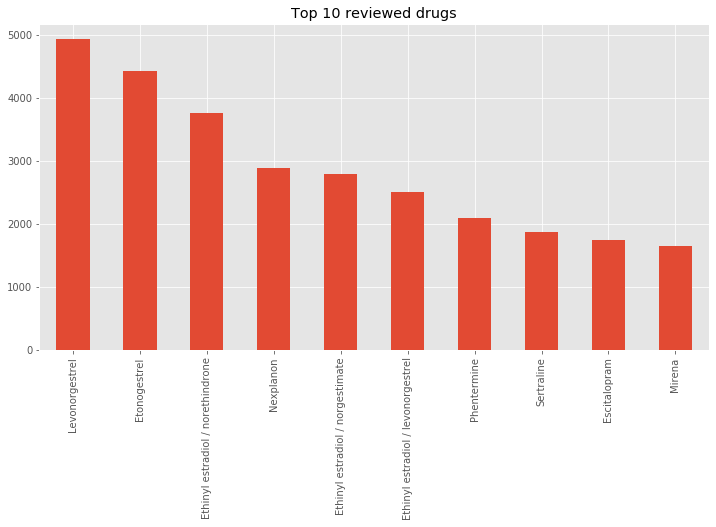

In [44]:
plot = drugs.drugName.value_counts().nlargest(10).plot(kind='bar', title="Top 10 reviewed drugs", figsize=(12,6))


# Top 10 most suffered condition by reviewers


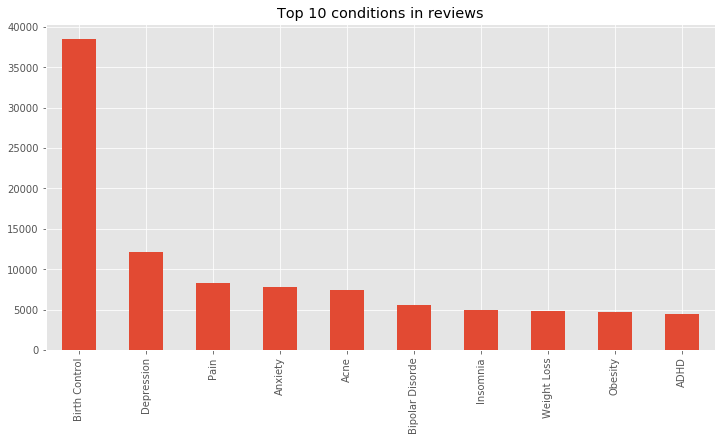

In [45]:
plot = drugs.condition.value_counts().nlargest(10).plot(kind='bar', title="Top 10 conditions in reviews", figsize=(12,6))

# Top 10 drugs with best and worst rating

Significant number of reviews: More than 30.0 reviews


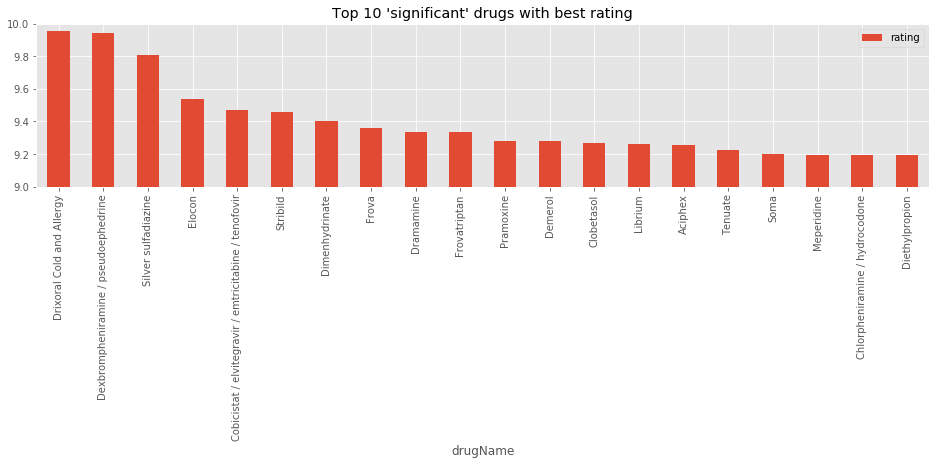

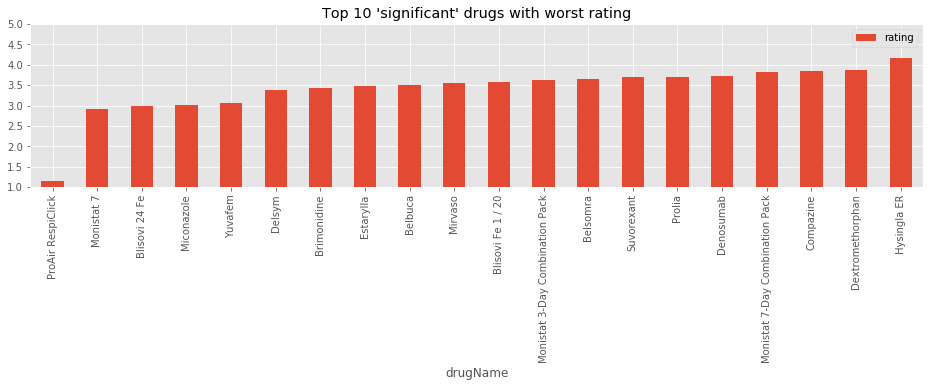

In [46]:
drugs_rating = drugs.groupby('drugName').agg({
    'rating': np.mean,
    'uniqueID': pd.Series.nunique
})

print("Significant number of reviews: More than", reviews_per_drug.quantile(q=0.75).values[0], "reviews")


drugs_rating = drugs_rating[drugs_rating['uniqueID'] > int(reviews_per_drug.quantile(q=0.75))]


top_drugs_rating = drugs_rating.nlargest(20, 'rating')
plot = top_drugs_rating.plot(y='rating', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 'significant' drugs with best rating") 
dummy = plt.ylim(9, 10) 

# Bottom 10
bottom_drugs_rating = drugs_rating.nsmallest(20, 'rating')
plot = bottom_drugs_rating.plot(y='rating', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 'significant' drugs with worst rating") 
dummy = plt.ylim(1, 5)

# Analyzing Pairs (Drug, Condition) with best and worst ratings

Number of pairs (Drug, Condition): 8586
Significant number of reviews: More than 12.0 reviews


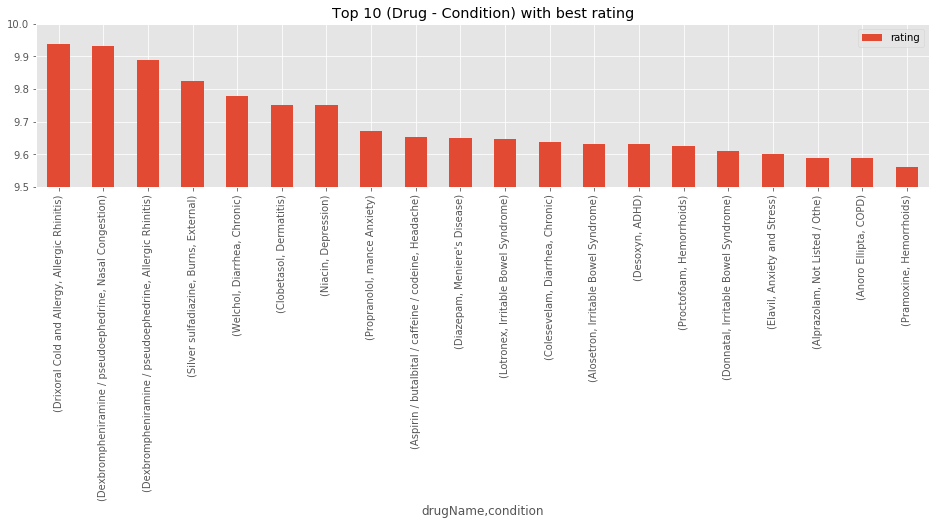

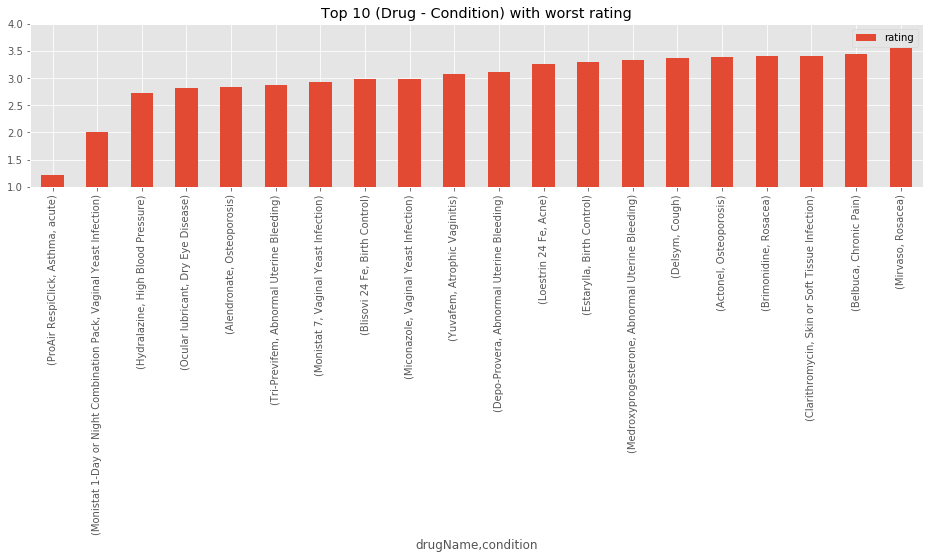

In [47]:
drugs_condition_rating = drugs.groupby(['drugName', 'condition']).agg({
    'rating': np.mean,
    'uniqueID': pd.Series.nunique
})

print("Number of pairs (Drug, Condition):", len(drugs_condition_rating))

print("Significant number of reviews: More than", drugs_condition_rating['uniqueID'].quantile(q=0.75), "reviews")

drugs_condition_rating = drugs_condition_rating[drugs_condition_rating['uniqueID'] > int(drugs_condition_rating['uniqueID'].quantile(q=0.75))]

top_drugs_condition_rating = drugs_condition_rating.nlargest(20, 'rating')
plot = top_drugs_condition_rating.plot(y='rating', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 (Drug - Condition) with best rating") 
dummy = plt.ylim(9.5, 10) 

bottom_drugs_condition_rating = drugs_condition_rating.nsmallest(20, 'rating')
plot = bottom_drugs_condition_rating.plot(y='rating', kind='bar', figsize = (16, 3))
dummy = plt.title("Top 10 (Drug - Condition) with worst rating") 
dummy = plt.ylim(1, 4) 

# We will analyze monthly patterns over different years of all the reviews

In [48]:
drugs["date_format"] = drugs["date"].apply( lambda x: datetime.strptime(x, '%d-%b-%y')) # Get date as a date object
drugs["month"] = drugs["date_format"].apply(lambda x: x.strftime('%m')) # Extract date month
drugs["year"] = drugs["date_format"].apply(lambda x: x.strftime('%Y')) # Extract date year
drugs["weekday"] = drugs["date_format"].apply(lambda x: x.strftime('%w'))

In [49]:
start_date = drugs["date_format"].min()
end_date = drugs["date_format"].max()

print("First review date: ", start_date)
print("Last review date: ", end_date)

First review date:  2008-02-24 00:00:00
Last review date:  2017-12-12 00:00:00


In [50]:
days_grouped = drugs.groupby(["year", "month"]) 
days_grouped = days_grouped.agg({
    'rating': np.mean,
    'usefulCount': np.sum,
    'uniqueID': pd.Series.nunique
})

different_months = len(days_grouped)

print("Months on dataset: ", different_months)

Months on dataset:  119


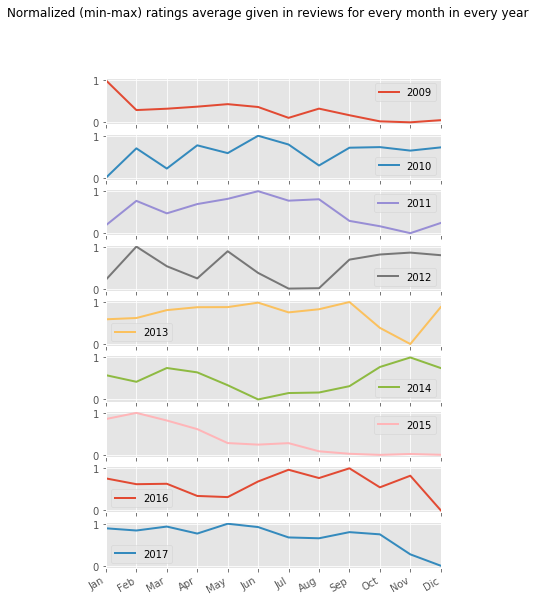

In [51]:
MME = MinMaxScaler() 

grouped = days_grouped.reset_index(level=1)
index_values = np.unique(grouped.index.values)[1:] 

months = pd.DataFrame()

for year in index_values:
    months[year] = grouped.loc[year,:]["rating"].values 
months_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dic"]

months.iloc[:,:] = MME.fit_transform(months) 

plots = months.plot(subplots=True, legend=True, figsize=(6,10), lw=2, title="Normalized (min-max) ratings average given in reviews for every month in every year")
for plot in plots:
    x = plot.set_ylim([-0.05, 1.05]) 
x = plt.xticks(range(0, len(months_labels)), months_labels)
